# How to Implement a Gradient Boosting Machine that Works with Any Loss Function

> Understand Freedman's original gradient boosting algorithm that uses decision trees to minimize any loss function.

- toc: false
- badges: true
- comments: true
- categories: [gradient boosting]
- hide: false
- image: images/gbm_plot.png


Well I've been alluding to this capability for several posts now, so it's time we get down to business and look at how Freedman's original GBM treated custom loss functions. This will help us complete our understanding of the original GBM algorithm, and it will help us begin to appreciate why, in practical situations, we will almost always be better off using variants like XGBoost or LightGBM, especially when we want to use custom losses. We'll see more on these state-of-the-art boosting algos in future posts.

## Freedman's GBM Algorithm 
In a previous post I outlined a general algorithm for gradient boosting with an arbitrary loss function, but it was presented to serve our intuition and was therefore a little bit hand-wavy. 
This time let's get specific enough to implement it in code. 
We'll use Freedman's original gradient boost algorithm from page 5 of the paper (translated into the notation we've been using so far). 

Like last time, we have training data $(\mathbf{y}, \mathbf{X})$ where $\mathbf{y}$ is a length-$n$ vector of target values, and $mathbf{X}$ is an $n \times p$ matrix with $n$ observations of $p$ features. We also have a differentiable loss function $L(\mathbf{y}, \mathbf{\hat{y}}) = \sum_{i=1}^n l(y_i, \hat{y}_i)$, a "learning rate" hyperparameter $\eta$, and a fixed number of model iterations $M$.

**Algorithm** gradient_boost$(\mathbf{X},\mathbf{y},L,\eta, M)$ returns: model $F_M$

1. Let base model
$F_0(\mathbf{x}) = c$, where $c = \text{argmin}_{c} \sum_{i=1}^n l(y_i, c)$

1. `for` $m$ = $0$ to $M-1$:

1. 
&nbsp;&nbsp;&nbsp;&nbsp;
Let "pseudo-residual" vector 
$\mathbf{r}_m = -\nabla_{\mathbf{\hat{y}}_m} L(\mathbf{y},\mathbf{\hat{y}}_m)$

1. 
&nbsp;&nbsp;&nbsp;&nbsp;
Train decision tree regressor $h_m(\mathbf{X})$ to predict $\mathbf{r}_m$ (minimizing squared error)

1. 
&nbsp;&nbsp;&nbsp;&nbsp;
`foreach` terminal leaf node $t \in h_m$:

1. 
&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;
Let $v = \text{argmin}_v \sum_{i \in t} l(y_i, F_m(\mathbf{x}_i) + v)$

1. 
&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;
Set terminal leaf node $t$ to predict value $v$

1. 
&nbsp;&nbsp;&nbsp;&nbsp;
$F_{m+1}(\mathbf{X}) = F_{m}(\mathbf{X}) + \eta h_m(\mathbf{X})$

1. Return composite  model $F_M$


By now, most of this is already familiar to us. 
We begin by setting the base model $F_0$ equal to the constant prediction value that minimizes the loss over all examples in the training dataset (line 1).
Then we begin the boosting iterations (line 2), each time computing the negative gradients of the loss with respect to the current model predictions (known as the pseudo residuals) (line 3).
We then fit our next decision tree regressor to predict the pseudo residuals (line 4). 

Then we encounter something new on lines 5-7.
When we fit a vanilla decision tree regressor to predict pseudo residuals, we're using mean squared error as the loss function to train the tree.
As you might imagine, this works well when the global loss function is also squared error.
But if we want to use a global loss other than squared error, there is an additional trick we can use to further increase the composite model's accuracy.
The idea is to continue using squared error to train each decision tree, keeping its structure and split conditions but altering the predicted value in each leaf to help minimize the global loss function.
Instead of using the mean target value as the prediction for each node (as we would do when minimizing squared error), we use a numerical optimization method like line search to choose the constant value for that leaf that leads to the best overall loss. This is the same thing we did in line 1 of the algorithm to set the base prediction, but here we choose the optimal prediction for each terminal node of the newly trained decision tree.

## Implementation
I did some half-assed searching on the interweb for an implementation of GBM that allows the user to provide a custom loss function, and you know what? I couldn't find anything. If you find another implementation, post in the comments so we can learn from it too.

Since we need to rip open the decision trees and modify the values predicted by their terminal nodes, we'll want to brush up on the scikit-learn [decision tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html) before we get going. Here's the notebook where I figured out  all the sklearn decision tree hacks and modifications that we'll use to reassign the values predicted in the leaf nodes; it also includes the GBM implementation, which turned out as follows.

## GBM Implementation

In [37]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor 
from scipy.optimize import minimize

class GradientBoostingMachine():
    '''Gradient Boosting Machine supporting any user-supplied loss function.'''
    
    def __init__(self, n_trees, learning_rate=0.1, max_depth=1):
        self.n_trees=n_trees; 
        self.learning_rate=learning_rate
        self.max_depth=max_depth;
    
    def fit(self, X, y, objective):
        '''Fit the GBM using the specified loss function.'''
        self.trees = []
        self.base_prediction = self._get_optimal_base_value(y, objective.loss)
        current_predictions = self.base_prediction * np.ones(shape=y.shape)
        for _ in range(self.n_trees):
            pseudo_residuals = objective.negative_gradient(y, current_predictions)
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, pseudo_residuals)
            self._update_terminal_nodes(tree, X, y, current_predictions, objective.loss)
            current_predictions += self.learning_rate * tree.predict(X)
            self.trees.append(tree)
     
    def _get_optimal_base_value(self, y, loss):
        '''Find the optimal initial prediction for the base model.'''
        fun = lambda c: loss(y, c)
        c0 = y.mean()
        return minimize(fun=fun, x0=c0).x[0]
        
    def _update_terminal_nodes(self, tree, X, y, current_predictions, loss):
        '''Update the tree's predictions according to the loss function.'''
        # terminal node id's
        leaf_nodes = np.nonzero(tree.tree_.children_left == tree.tree_.children_right)[0]
        # compute leaf for each sample in ``X``.
        leaf_node_for_each_sample = tree.apply(X)
        for leaf in leaf_nodes:
            samples_in_this_leaf = np.where(leaf_node_for_each_sample == leaf)[0]
            val = self._get_optimal_leaf_value(y.take(samples_in_this_leaf, axis=0), 
                                               current_predictions.take(samples_in_this_leaf, 
                                                                        axis=0),
                                               loss)
            tree.tree_.value[leaf, 0, 0] = val
            
    def _get_optimal_leaf_value(self, y, current_predictions, loss):
        '''Find the optimal prediction value for a given leaf.'''
        fun = lambda c: loss(y, current_predictions + c)
        c0 = y.mean()
        return minimize(fun=fun, x0=c0).x[0]
          
    def predict(self, X):
        '''Generate predictions for the given input data.'''
        return (self.base_prediction 
                + self.learning_rate 
                * np.sum([tree.predict(X) for tree in self.trees], axis=0))

In terms of design, we implement a class for the GBM with scikit-like `fit` and `predict` methods. Notice in the below implementation that the `fit` method is only 10 lines long, and corresponds very closely to Freedman's algorithm from above.  Most of the complexity comes from the helper methods for updating the leaf values according to the specified loss function.

When the user wants to call the `fit` method, they'll need to supply the loss function they want to use for boosting. We'll make the user implement their loss (a.k.a. objective) function as a class with two methods: (1) a `loss` method taking the labels and the predictions and returning the loss score and (2) a `negative_gradient` method taking the labels and the predictions and returning an array of negative gradients.

Let's try it out with a few different loss functions!


### Mean Squared Error
MSE loss produces estimates of the mean target value conditioned on the feature values. Here's the implementation.

In [1]:
#hide
import matplotlib.pyplot as plt 
%matplotlib inline

In [38]:
#hide
rng = np.random.default_rng()
x = np.linspace(0, 10, 500)
y = np.where(x < 5, x, 5) + rng.normal(0, 0.4, size=x.shape)
x = x.reshape(-1,1)

In [39]:
class SquaredErrorLoss():
    
    def loss(self, y, y_hat):
        return np.mean((y - y_hat)**2)
    
    def negative_gradient(self, y, y_hat):
        return y - y_hat

In [40]:
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5)
gbm.fit(x, y, SquaredErrorLoss())

Text(0.5, 1.0, 'model predicting mean or y | x')

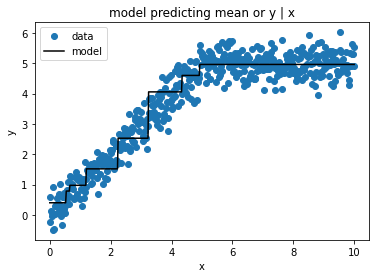

In [41]:
#hide_input
# fig, ax = plt.subplot()
plt.plot(x.ravel(), y, 'o', label='data')
plt.plot(x.ravel(), gbm.predict(x), '-k', label='model')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('model predicting mean or y | x');

### Mean Absolute Error
MAE loss produces estimates of the median target value conditioned on the feature values. Here's the implementation.

In [42]:
#hide
rng = np.random.default_rng()
x = np.linspace(0, 10, 500)
y = np.where(x < 5, x, 5) + rng.normal(0, 0.4, size=x.shape)
x = x.reshape(-1,1)

In [43]:
class AbsoluteErrorLoss():
    
    def loss(self, y, y_hat):
        return np.mean(np.abs(y - y_hat))
    
    def negative_gradient(self, y, y_hat):
        return np.sign(y - y_hat)

In [44]:
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5)
gbm.fit(x, y, AbsoluteErrorLoss())

Text(0.5, 1.0, 'model predicting median of y | x')

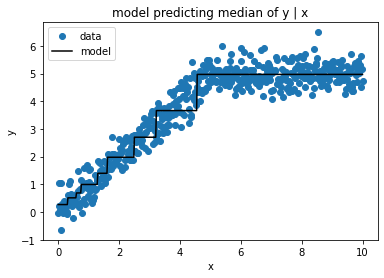

In [45]:
#hide_input
# fig, ax = plt.subplot()
plt.plot(x.ravel(), y, 'o', label='data')
plt.plot(x.ravel(), gbm.predict(x), '-k', label='model')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('model predicting median of y | x');

### Quantile Loss
Quantile loss yields estimates of a given quantile of the target variable conditioned on the features. Here's my implementation.

In [46]:
#hide
rng = np.random.default_rng()
x = np.linspace(0, 10, 500)
# y = np.where(x < 5, x, 5) + rng.uniform(-2, 2, size=x.shape)
y = np.where(x < 5, x, 5) + rng.normal(0, 1, size=x.shape)
x = x.reshape(-1,1)

In [47]:
class QuantileLoss():
    
    def __init__(self, alpha):
        if alpha < 0 or alpha >1:
            raise ValueError('alpha must be between 0 and 1')
        self.alpha = alpha
        
    def loss(self, y, y_hat):
        e = y - y_hat
        return np.mean(np.where(e > 0, self.alpha * e, (self.alpha - 1) * e))
    
    def negative_gradient(self, y, y_hat):
        e = y - y_hat 
        return np.where(e > 0, self.alpha, self.alpha - 1)

In [48]:
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5)
gbm.fit(x, y, QuantileLoss(alpha=0.9))

Text(0.5, 1.0, 'model predicting 0.9 quantile of y | x')

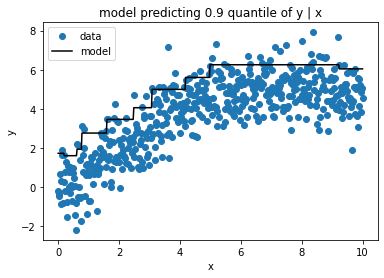

In [49]:
#hide_input
plt.plot(x, y, 'o', label='data')
plt.plot(x, gbm.predict(x), 'k-', label='model')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('model predicting 0.9 quantile of y | x');

### Binary Cross Entropy
All the previous losses were for regression problems. But we can also do classification, simply by using the right loss function. Here we'll implement binary cross entropy, a.k.a. binary deviance, sometimes abusively called log loss. One thing to remember is that, like logistic regression, our model is really predicting the log odds ratio, not the probability of the positive class. Thus I do an expit transformation before computing loss and the gradients and another one before plotting the predictions.

In [50]:
#hide
rng = np.random.default_rng()
x = np.linspace(-3, 3, 500)
expit = lambda t: np.exp(t) / (1 + np.exp(t))
p = expit(x)
y = rng.binomial(1, p, size=p.shape)
x = x.reshape(-1,1)

In [51]:
class BinaryCrossEntropyLoss():
    # in these methods, y_hat gives the log odds ratio
    
    def __init__(self):
        self.expit = lambda t: np.exp(t) / (1 + np.exp(t))
    
    def loss(self, y, y_hat):
        p = self.expit(y_hat)
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    
    def negative_gradient(self, y, y_hat):
        p = self.expit(y_hat)
        return y / p - (1 - y) / (1 - p)

In [52]:
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=0.5)
gbm.fit(x, y, BinaryCrossEntropyLoss())

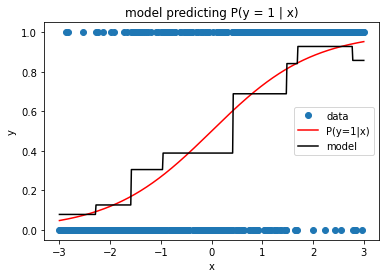

In [53]:
#hide_input
plt.plot(x, y, 'o', label='data')
plt.plot(x, p, '-r', label='P(y=1|x)')
plt.plot(x, expit(gbm.predict(x)), '-k', label='model')
plt.title('model predicting P(y = 1 | x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

## Wrapping Up
Alrighty, there it is, an implementation of the gradient boosting machine that can handle whatever loss function your heart desires (as long as you can write down its derivative). I really had fun bringing this one to life since it solidifies a lot of the (sometimes mathy) ideas we've been covering about gradient boosting, and it removes any remaining doubt about the gradient boost algorithm from Freedman's classic paper. As I mentioned in the intro, in real life we will more or less always be better off using modern boosting frameworks like XGBoost, rather than the classic GBM. And as luck would have it, we'll dive into the details of these modern Newton descent boosting frameworks in future posts.
